In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
def extract_frames_from_folder(folder_path):
    video_data = []
    video_names = []
    for video_file in os.listdir(folder_path):
        if video_file.endswith(".mp4") or video_file.endswith(".avi"):
            video_path = os.path.join(folder_path, video_file)
            cap = cv2.VideoCapture(video_path)
            frames = []
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                frames.append(gray)
            cap.release()
            video_data.append(frames)
            video_names.append(video_file)
    return video_data, video_names


In [3]:
def detect_keypoints(frame):
    # Using goodFeaturesToTrack to detect points
    keypoints = cv2.goodFeaturesToTrack(frame, maxCorners=50, qualityLevel=0.01, minDistance=10)
    return np.squeeze(keypoints) if keypoints is not None else []

In [4]:
def track_keypoints(frames, keypoints):
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    motion_vectors = []
    prev_frame = frames[0]
    prev_points = keypoints.astype(np.float32)

    for i in range(1, len(frames)):
        next_frame = frames[i]
        next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_frame, next_frame, prev_points, None, **lk_params)
        valid_points = next_points[status.flatten() == 1]
        prev_points = valid_points
        prev_frame = next_frame
        
        # Calculate motion vectors
        if len(valid_points) > 0:
            motion = valid_points - keypoints[:len(valid_points)]
            motion_vectors.append(motion)

    return motion_vectors 

In [5]:
def aggregate_motion_features(motion_vectors):
    aggregated_features = []
    for motion in motion_vectors:
        if motion.size > 0:
            # Extract mean, max displacement, and standard deviation
            mean_displacement = np.mean(np.linalg.norm(motion, axis=1))
            max_displacement = np.max(np.linalg.norm(motion, axis=1))
            std_displacement = np.std(np.linalg.norm(motion, axis=1))
            aggregated_features.append([mean_displacement, max_displacement, std_displacement])
    return np.array(aggregated_features)

In [6]:
def cluster_videos(features, n_clusters=4):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(reduced_features)
    return reduced_features, labels

In [7]:
def visualize_clusters(reduced_features, labels, video_names):
    plt.figure(figsize=(10, 7)) 
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        cluster_points = reduced_features[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {label}")

    plt.title("Clustered Videos Based on Heart Motion")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()

In [8]:
def determine_optimal_k(features, max_k=10):
    wcss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        wcss.append(kmeans.inertia_)  
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='-', color='b')
    plt.title("Elbow Method for Determining Optimal K")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
    plt.xticks(range(1, max_k + 1))
    plt.grid(True)
    plt.show()

def main(folder_path):
    video_data, video_names = extract_frames_from_folder(folder_path)
    all_features = []

    for frames in video_data:
        keypoints = detect_keypoints(frames[0]) 
        motion_vectors = track_keypoints(frames, keypoints)
        features = aggregate_motion_features(motion_vectors)

        if len(features) > 0 and features.ndim == 2:  
            feature_vector = np.mean(features, axis=0)  
        else:
            feature_vector = [0, 0, 0]  
        all_features.append(feature_vector)

    all_features_array = np.array(all_features)
    
    determine_optimal_k(all_features_array, max_k=10)
    
    reduced_features, labels = cluster_videos(all_features_array, n_clusters=3)
    
    visualize_clusters(reduced_features, labels, video_names)
    
    results_df = pd.DataFrame({"FileName": video_names, "Cluster ID": labels})
    results_df.to_csv("Final.csv", index=False)
    print("Final.csv created successfully!")


In [9]:
def main(folder_path):
    video_data, video_names = extract_frames_from_folder(folder_path)
    all_features = []

    for frames in video_data:
        keypoints = detect_keypoints(frames[0]) 
        motion_vectors = track_keypoints(frames, keypoints)
        features = aggregate_motion_features(motion_vectors)

        if len(features) > 0 and features.ndim == 2:
            feature_vector = np.mean(features, axis=0)  
        else:
            feature_vector = [0, 0, 0]  
        all_features.append(feature_vector)

    all_features_array = np.array(all_features)

    determine_optimal_k(all_features_array, max_k=10)
    
    reduced_features, labels = cluster_videos(all_features_array)
    
    visualize_clusters(reduced_features, labels, video_names)
    
    results_df = pd.DataFrame({"FileName": video_names, "Cluster ID": labels})
    results_df.to_csv("Final.csv", index=False)
    print("Final.csv created successfully!")



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

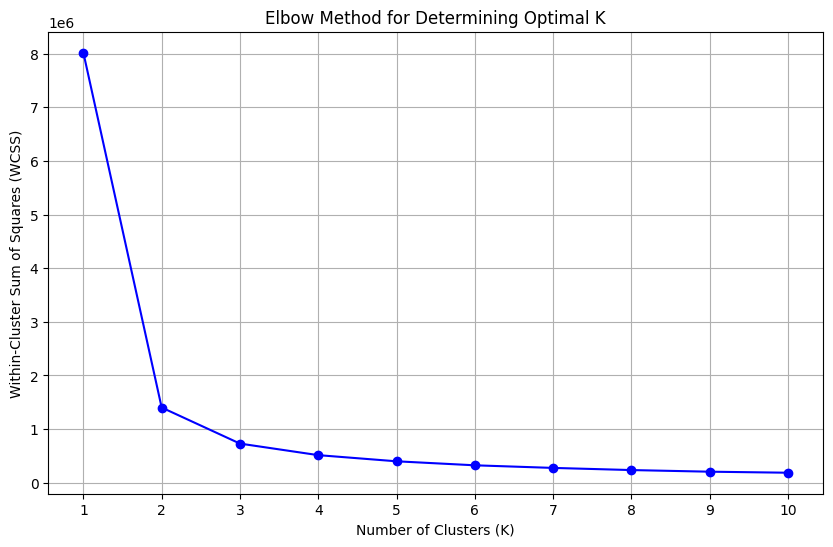

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


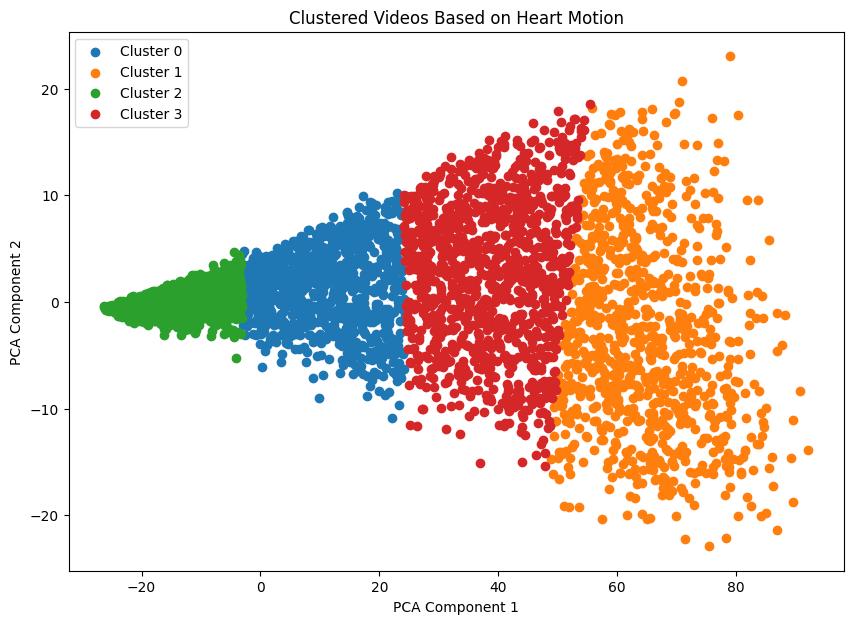

Final.csv created successfully!


In [10]:
folder_path = "/kaggle/input/echonet-dynamic/EchoNet-Dynamic/Videos"  
main(folder_path)
